Epoch 1/7
6/6 [==============================] - 2s 145ms/step - loss: 17.1024 - accuracy: 0.5089 - val_loss: 4.3061 - val_accuracy: 0.5814
Epoch 2/7
6/6 [==============================] - 0s 83ms/step - loss: 2.5324 - accuracy: 0.6923 - val_loss: 2.0349 - val_accuracy: 0.6744
Epoch 3/7
6/6 [==============================] - 0s 80ms/step - loss: 0.8069 - accuracy: 0.7751 - val_loss: 0.5489 - val_accuracy: 0.7442
Epoch 4/7
6/6 [==============================] - 0s 78ms/step - loss: 0.2721 - accuracy: 0.8935 - val_loss: 0.4806 - val_accuracy: 0.7907
Epoch 5/7
6/6 [==============================] - 0s 79ms/step - loss: 0.0866 - accuracy: 0.9704 - val_loss: 0.2654 - val_accuracy: 0.9070
Epoch 6/7
6/6 [==============================] - 1s 85ms/step - loss: 0.0775 - accuracy: 0.9704 - val_loss: 0.5055 - val_accuracy: 0.7907
Epoch 7/7
2/2 [==============================] - 0s 18ms/step - loss: 0.1056 - accuracy: 0.9630
Test Accuracy: 0.96


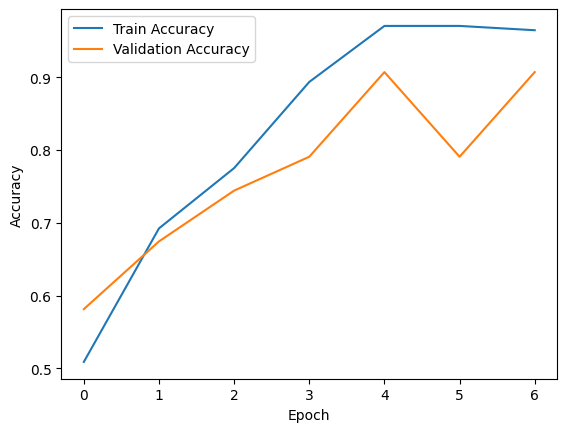

In [8]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.models as models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 데이터 경로 설정
split_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitCar"
split_no_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitNoCar"

# 오디오 데이터를 읽고 특징 추출 (MFCC)
def extract_features(file_path, max_pad_len=199, target_sample_rate=48000):
    # 오디오 데이터를 48kHz로 리샘플링
    audio, sample_rate = librosa.load(file_path, sr=target_sample_rate, res_type='kaiser_fast')
    # MFCC 추출 (40개의 MFCC, 25ms 윈도우, 10.7ms 스텝)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)
    # 패딩 또는 자르기
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

# 데이터 준비
def prepare_dataset(car_folder, no_car_folder, target_sample_rate=48000):
    data = []
    labels = []
    # 자동차 소리 데이터
    for file_name in os.listdir(car_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(car_folder, file_name)
            features = extract_features(file_path, target_sample_rate=target_sample_rate)
            data.append(features)
            labels.append('car')

    # 비자동차 소리 데이터
    for file_name in os.listdir(no_car_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(no_car_folder, file_name)
            features = extract_features(file_path, target_sample_rate=target_sample_rate)
            data.append(features)
            labels.append('no_car')

    return np.array(data), np.array(labels)

# 데이터 로드 및 전처리
X, y = prepare_dataset(split_car_folder, split_no_car_folder, target_sample_rate=48000)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'car' -> 0, 'no_car' -> 1
X = X[..., np.newaxis]  # CNN 입력 형태로 변경

# 학습 및 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# CNN 모델 설계
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(16, (5, 5), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # 드롭아웃 비율 증가
        layers.Dense(1, activation='sigmoid')  # 이진 분류
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 학습
input_shape = X_train.shape[1:]
model = create_model(input_shape)
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_split=0.2)

# 성능 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 저장
model.save("car_detection_cnn_model2_48kHz.h5")
